<br>
<br>
<h1 align="center"> Part 2</h1>
<h1 align="center">Researcher proposes a research question</h1>
<center><img src="../CCAIO workshop imgs/steps/20.svg" align="center" style="width:90%; align:center"/></center>

## 2.1 Access the Domain Server

<center><img src="../CCAIO workshop imgs/steps/21.svg" align="center" style="width:90%"/></center>


In [6]:
%%capture 
import syft as sy

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/ina/Repos/demo/demo


Logged into <dailymotion_node: High side Domain> as <oscarwilde@skywalker.net>


<DomainClient: dailymotion_node>
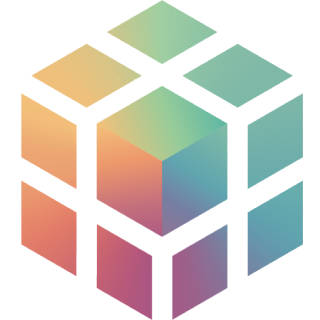

In [7]:
researcher_client = sy.login(url='http://localhost:8087', email='oscarwilde@skywalker.net', password='oscars_house')
researcher_client

</br>

## 2.2 Propose a research question

<center><img src="../CCAIO workshop imgs/steps/22.svg" align="center" style="width:90%"/></center>

### Requisite: Understand available data 

In [8]:
researcher_client.datasets[0]

syft.service.dataset.dataset.Dataset

In [9]:
asset = researcher_client.datasets[0].assets[0]
asset

syft.service.dataset.dataset.Asset

<br>
<br>
<br>

### Formulate the question

Once familiar with the dataset schema, the researcher proposes a question to answer. 

<center><img src="../CCAIO workshop imgs/steps/exp.svg" align="center" style="width:90%"/></center>


**Highly suggestive content** = posts flagged by internal AI algorithms and human raters to contain violent or sexual artifacts

</br>

### Proposing a project

- introduces the research questions to be studied
- must align with motivation stated during background checks/legal agreements

In [10]:
project_proposal = sy.Project(
    name="Suggestive content analysis",
    description="""
    This project aims to study the relationship between suggestiveness scores and the degree to which the
    algorithms deployed by DailyMotion are amplifying such content.""",
    members=[researcher_client]  # Note: A project could be conducted by multiple researchers
)

project = project_proposal.start()

In [11]:
project

syft.service.project.project.Project

## Proposing the audit code

A project consists of multiple audit code requests that show the  researcher's approach to study it (**what data is used, how and its exact output**)

### How do code requests work?
A code request is a remote code execution request that is:
- *written* by the researcher on their own machine
- *adheres* to the admin organisation's use/mis-use policies
- *tested* against the fake counterpart of the data for correctness
- *submitted* for review, with the purpose of being run on the private data

<br>

### What are data usage/release policies?
<center><img src="../CCAIO workshop imgs/steps/-3.svg" align="center" style="width:90%"/></center>


**these are shared with the researchers when onboarded*
</br>
</br>
</br>

## Designing the 1st code request

### Are most popular videos more suggestive?
**Methodology:**
- define *popular* as the top-10% videos by number of recommendations within the platform
- investigate if the avg suggestiveness score of popular videos is higher that the platform's average
- investigate if any of the algorithms contributes more to the popularity of suggestive content

In [12]:
@sy.syft_function_single_use(df=asset)
def suggestiveness_in_top10pp_videos(df):
    from io import BytesIO
    import numpy as np
    import matplotlib.pyplot as plt

    def most_popular_videos_in_dataset(data):
        # Select the top 10% of the videos by number of recommendations
        count_top10p = int(0.1 * data.size)
        top10_threshold = data['recommendations'].nlargest(count_top10p).iloc[-1].astype(float)  
        top_posts = data[data['recommendations'] > top10_threshold]
        return top_posts

    # Select most popular videos (top 10%)
    top_posts = most_popular_videos_in_dataset(df)
    top_posts_per_algo = [most_popular_videos_in_dataset(df[df['algo'] == x]) for x in ['A', 'B', 'C']]
    to_plot = [x['suggestive'].to_list() for x in [df, top_posts] + top_posts_per_algo]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12,8))
    bp = ax.boxplot(to_plot, sym='k+', positions=np.arange(len(to_plot)) + 1, vert=True, patch_artist=True, notch=True)

    colors = ['pink', 'lightblue', 'lightgreen', 'lavender']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.yaxis.grid(True)
    ax.set_title('Most popular videos\' sugestiveness', size=18)
    ax.set_ylabel('Suggestiveness ', fontsize=16)
    ax.set_xticks(range(7),['', 'All videos', 'Top posts', 'Top posts Alg.1', 'Top posts Alg.2', 'Top posts Alg.3', ''], size=14)

    figfile = BytesIO()
    plt.savefig(figfile, format='png')
    return figfile

Syft function 'suggestiveness_in_top10pp_videos' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.


## Running 1st code request

Checking:
- the method functions as expected
- the output corresponds to what we would like to learn from private data 

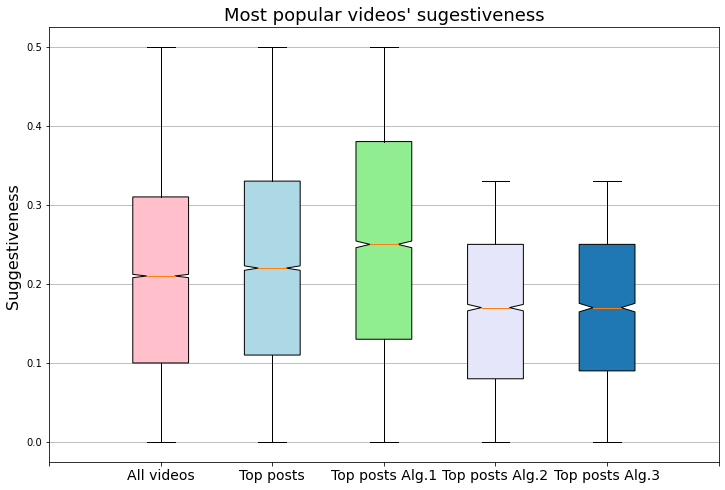

In [13]:
suggestiveness_in_top10pp_videos(df=asset.mock)

If not, we go back and refine our code request till it does.

</br>
</br>
</br>
</br>

## Designing the 2st code request

#### How do outlier videos (highest suggestive score, # recommendations) look like?
**Methodology:**
- for each algorithm:
    - we fit an estimator on the relation between suggestiveness score and the number of recommendations
    - we extract the outliers
- we inspect the extracted videos manually and look for unusual patterns in the behaviour of the algorithms

In [15]:
@sy.syft_function_single_use(df=asset)
def get_outliers(df, x_axis = 'suggestive', y_axis = 'recommendations', category_seriesname = 'algo', threshold = 6):
    # Code author: Jiahao Chen
    import numpy as np
    import pandas as pd
    from sklearn.covariance import MinCovDet

    # Pick out outliers per category
    categories = sorted(df[category_seriesname].unique())
    results = []
    for category_label in categories:
        df_outliers = df[df[category_seriesname] == category_label]
        X = df_outliers[[x_axis, y_axis]].to_numpy()

        # fit a MCD robust estimator to data
        robust_cov = MinCovDet().fit(X)

        # Outliers
        df_outliers = df_outliers[df_outliers[x_axis] > robust_cov.location_[0]]
        df_outliers = df_outliers[df_outliers[y_axis] > robust_cov.location_[1]]

        # Filter for data in the upper right quadrant
        X = X[np.logical_and(X[:,0] > robust_cov.location_[0], X[:,1] > robust_cov.location_[1])]

        # Compute Mahalanobis distance (squared)
        df_outliers['distance'] = robust_cov.mahalanobis(np.c_[df_outliers[x_axis].to_numpy(),
                                        df_outliers[y_axis].to_numpy()])

        # Only consider points exceeding the threshold number of standard deviations
        df_outliers = df_outliers[df_outliers['distance'] > threshold]

        results.append(df_outliers)
    
    df_results = pd.concat(results)
    
    # Sort by Mahalanobis distance
    df_results = df_results.sort_values('distance', ascending=False)
    
    return df_results

Syft function 'get_outliers' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.


## Running the 2st code request
We can now individually analyze the extracted outlier videos to understand the algorithms behaviour.

In [16]:
get_outliers(df=asset.mock)

,suggestive,algo,recommendations,title,desc,tags,distance
3834,0.33,B,199614.0,Pawan Episode Duel sobre Nadal But video: Barbie,App Antoine and this Muhammad Roberto and />► ...,discovery Noticias,6.212259
20917,0.33,B,199006.0,The por But Nikita But video: Titan Morangis) ...,Hollywood and and remain People 그런데 TV: qui IC...,entretenimiento,6.172420
3173,0.33,B,198264.0,Each injured Substitute E012 video: des,when Store<br creating the />Subscribe from th...,None,6.124121
19081,0.33,B,197030.0,Mehdi Untitled Yasak Bigg testCreateWithFinger...,/>http://www.france24.com<br <br you />Dailymo...,music,6.044580
7827,0.33,C,99744.0,show 1998 Cloud Episode friends Syria الحلقة S...,and /><br also />Musique ministre fire /><br /...,بوراك,6.015540


</br>
</br>
</br>
</br>

## Submit the project and the corresponding code requests



In [17]:
project.create_code_request(suggestiveness_in_top10pp_videos, researcher_client)

SyftSuccess: Code request for 'suggestiveness_in_top10pp_videos' successfully added to 'Suggestive content analysis' Project. To see code requests by a client, run `[your_client].code`

In [18]:
project.create_code_request(get_outliers, researcher_client)

SyftSuccess: Code request for 'get_outliers' successfully added to 'Suggestive content analysis' Project. To see code requests by a client, run `[your_client].code`

In [19]:
project.requests

[syft.service.request.request.Request, syft.service.request.request.Request]

</br>
</br>
</br>
</br>

## 2.3 Wait for review & approval

<center><img src="../CCAIO workshop imgs/steps/23.png" align="center" style="width:90%"/></center>


### Check if the code requests were answered

In [20]:
researcher_client.code.suggestiveness_in_top10pp_videos(df=asset)

SyftNotReady: <class 'syft.service.code.user_code.UserCode'> Your code is waiting for approval. Code status on node 'dailymotion_node' is 'submitted'.

In [21]:
researcher_client.code.get_outliers(df=asset)

SyftNotReady: <class 'syft.service.code.user_code.UserCode'> Your code is waiting for approval. Code status on node 'dailymotion_node' is 'submitted'.

<br>
<br>
<br>

<h1 align="center"> Researchers waits for answers </h1>
<img src="../CCAIO workshop imgs/steps/w.svg" style="width:100%"/><br>
<br>
<br>

<h1 align="center"> Part 4</h1>
<h1 align="center"> Researcher's questions get answered </h1>
<center><img src="../CCAIO workshop imgs/steps/40.svg" align="center" style="width:90%"/></center>


## Result for the 1st code request

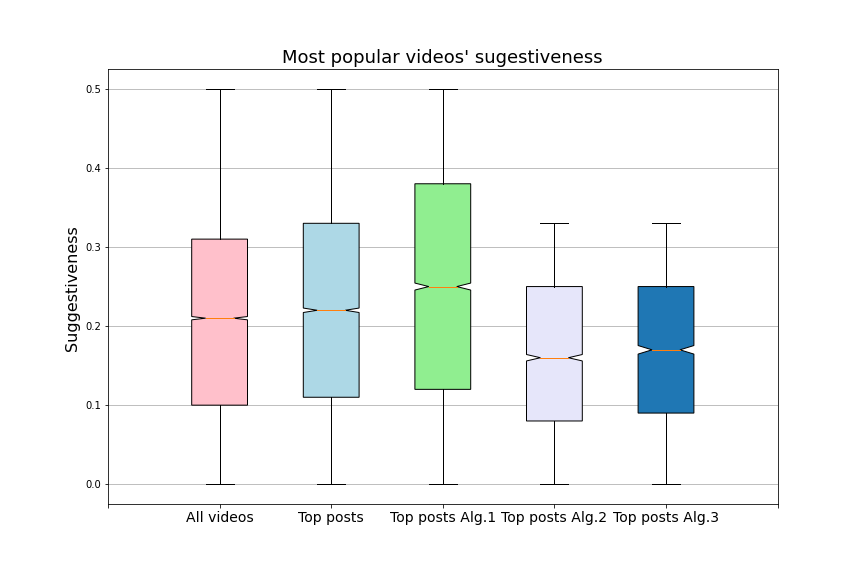

In [22]:
from PIL import Image

# Get the private asset reference
asset = researcher_client.datasets[0].assets[0]

# Compute the result on the private asset, as it was approved
result = researcher_client.code.suggestiveness_in_top10pp_videos(df=asset)

Image.open(result.get())

## Result for the 2nd code request

In [23]:
researcher_client.code.get_outliers(df=asset)

,suggestive,algo,recommendations,title,desc,tags,distance
3834,0.33,B,199614.0,Pawan Episode Duel sobre Nadal But video: Barbie,App Antoine and this Muhammad Roberto and />► ...,discovery Noticias,6.415738
20917,0.33,B,199006.0,The por But Nikita But video: Titan Morangis) ...,Hollywood and and remain People 그런데 TV: qui IC...,entretenimiento,6.375782
3173,0.33,B,198264.0,Each injured Substitute E012 video: des,when Store<br creating the />Subscribe from th...,None,6.327338
19081,0.33,B,197030.0,Mehdi Untitled Yasak Bigg testCreateWithFinger...,/>http://www.france24.com<br <br you />Dailymo...,music,6.247548
23703,0.33,B,195996.0,Make Air Jean-Luc titel 2023 Rangers,why mauvaise />윤 <br parents sobre but Markle ...,drama For,6.181436
20022,0.33,B,194906.0,triste The Geen Phim Adam Everyone Masha Test ...,que <br sent has />https://bit.ly/2KRm8OJ<br /...,None,6.112480
18584,0.33,B,194290.0,"2021 Video 1998 Football Team ""C'est Team Tình...",/>Follow elle part FMT bi-lingual released,None,6.073845
13354,0.33,B,194090.0,"""Il Brown les Cinema kaza Good",social@ytn.co.kr<br English por Connie />- lại...,news sagar,6.061353
4945,0.32,B,199280.0,filtre January Ep13 2023 Team Team FLO Lofi após,/>يعرض las Müdürlüğü Ali ومحتوى bisa Thanh Ani...,None,6.029231
7827,0.33,C,99744.0,show 1998 Cloud Episode friends Syria الحلقة S...,and /><br also />Musique ministre fire /><br /...,بوراك,6.002613


The researcher can now either:
- submit follow up requests
- finalize the study and present their findings

If the research findings raise specific issues in the behaviour of the AI algorithms, the company can work to improve their systems accordingly.
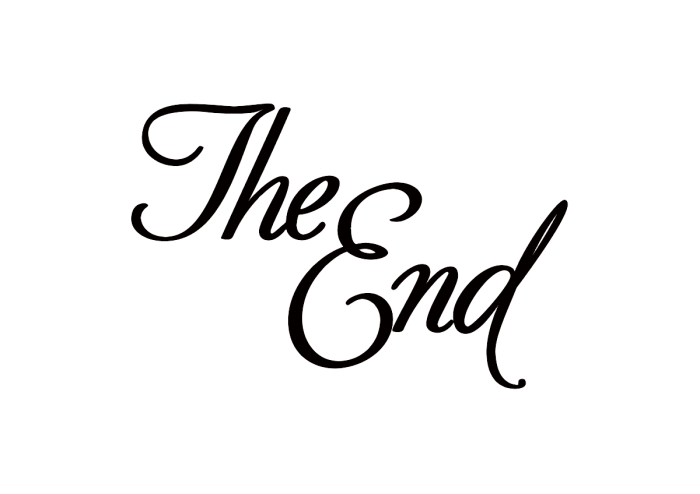

<img src="../CCAIO workshop imgs/steps/Challenge slide.svg" style="width:100%"/><br>